In [2]:
import pandas as pd

# Data Wrangling
import numpy as np 
import pandas as pd
import xlrd
import re
from collections import Counter

# Time Series
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotx
from highlight_text import HighlightText, ax_text, fig_text
import plotly.io as pio
import wordcloud
from matplotlib import font_manager
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib_venn_wordcloud import venn2_wordcloud
from matplotlib_venn import venn2, venn2_circles
from PIL import Image


# NLP
import spacy
import nltk
from bertopic import BERTopic
from nltk.corpus import stopwords
from textblob import TextBlob

nlp = spacy.load('en_core_web_trf')



In [155]:
def clean_df(df: pd.DataFrame):
    """
    Returns
    --------
    Cleansed pd.DataFrame

    Function drops any queries which are null and replaces null demos with Unknown. 
    Removes punctuation, extra spaces, replaces underscores and words over 14 characters.
    Removes stopwords from the corpus. 
    """
    df = (df.rename({'query':'search'}, axis=1)
            .loc[:, ['date', 'search', 'age', 'gender']]
            .dropna(subset=['search'])
            .fillna('Unknown')
            .assign(gender=lambda df: df['gender'].str.lower(),
                    date=pd.to_datetime(df['date'], format='%Y%m%d'),
                    search=lambda df: df['search'].str.replace('_', ' ')
                                                  .str.replace('(\S{14,})|[^\w\s]|  +', '') 
                                                  .str.strip()
                                                  .str.lower()))
    return df


venn = pd.read_csv('../raw data/menopause.csv').pipe(clean_df)

venn['gender'].value_counts()


unknown    1271
female      181
male        125
-1           31
Name: gender, dtype: int64

In [146]:

# Aesthetics

venn = pd.read_csv('../raw data/menopause.csv')
male = venn.query('gender == "Male"')
female = venn.query('gender =="Female"')
venn['gender'].str.lower()

# spacy doc for each gender
doc1 = nlp(" ".join(male['search'].to_list()))
male = [token.text for token in doc1 if not token.is_stop and not token.is_punct and token.pos_ in ['ADJ']]
male = Counter(male).most_common(25)

doc2 = nlp(" ".join(female['search'].to_list()))
female = [token.text for token in doc2 if not token.is_stop and not token.is_punct and token.pos_ in ['ADJ']]
female = Counter(female).most_common(25)

# combined doc for total word frequency
frequencies = dict(female + male) 

# move to dataframes
male = pd.DataFrame(male, columns=['search', 'count'])
female = pd.DataFrame(female, columns=['search', 'count'])

# work out intersections and unions
female_only = female.loc[~female['search'].isin(male['search']), 'search'].str.capitalize()
male_only = male.loc[~male['search'].isin(female['search']), 'search'].str.capitalize()
in_both = male.loc[male['search'].isin(female['search']), 'search'].str.capitalize()





AttributeError: Can only use .str accessor with string values!

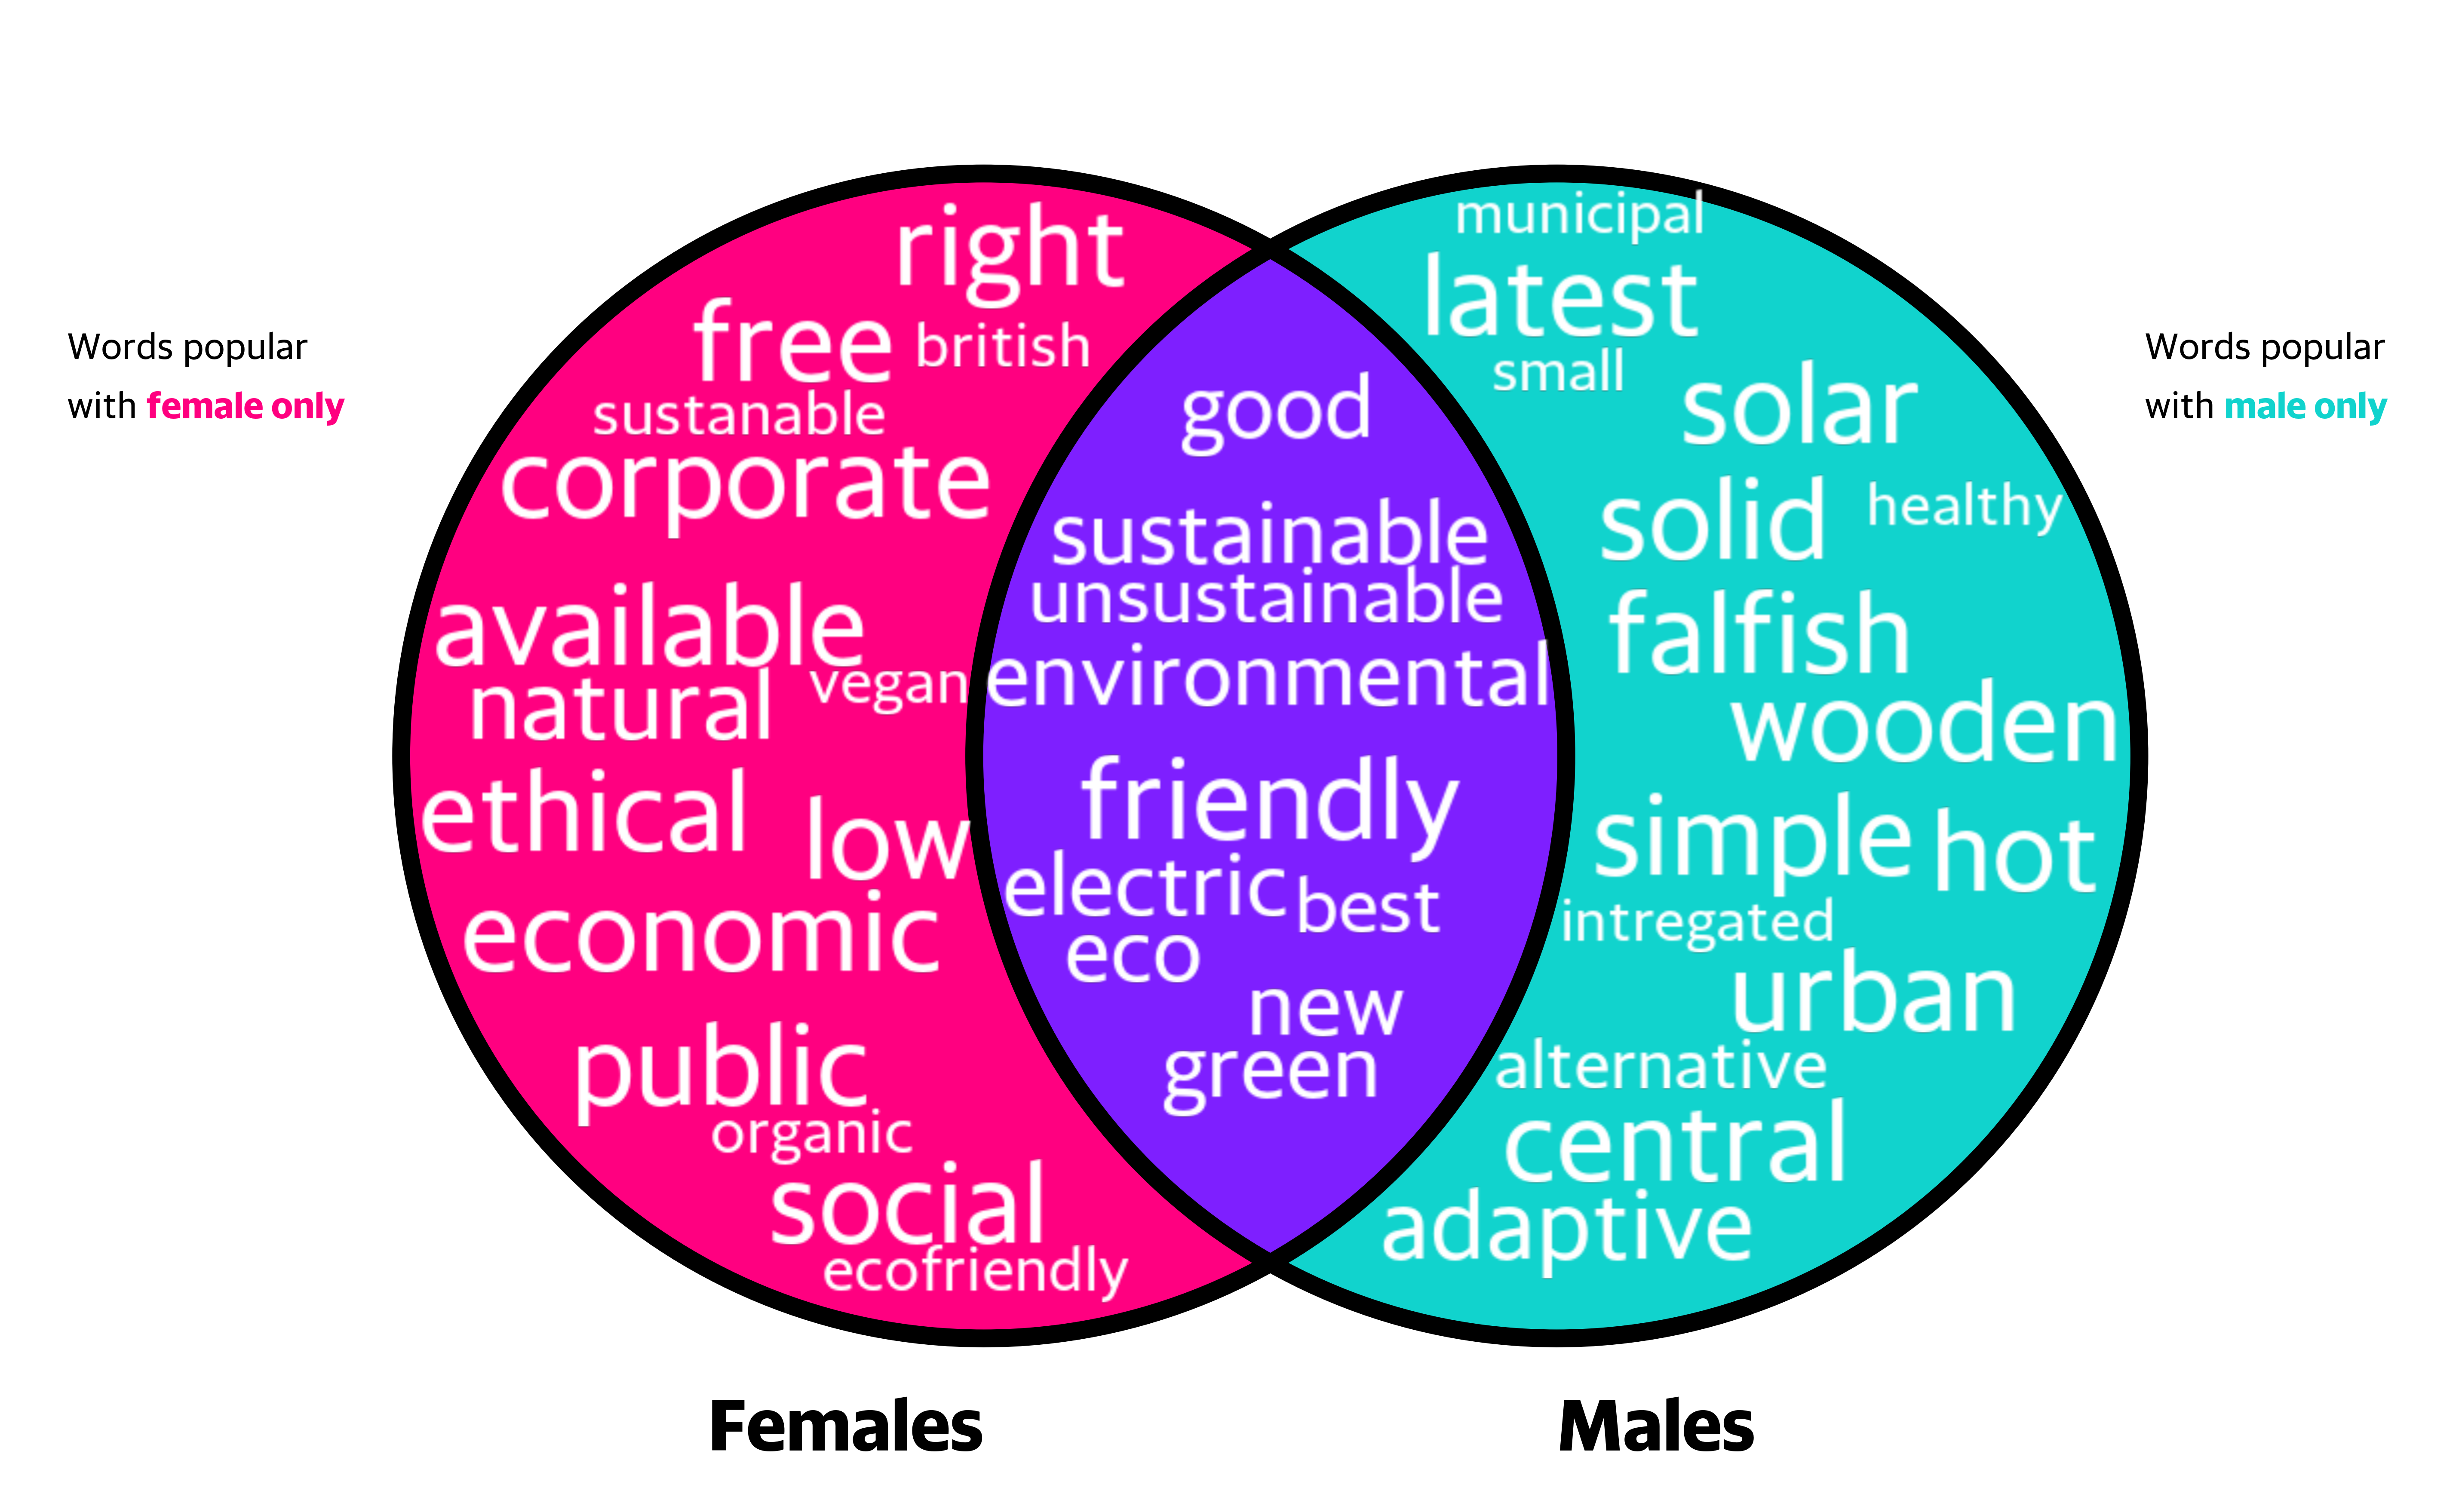

In [139]:
font = {'family' : 'Yahoo Sans', 'weight' : 'bold'}
plt.rc('font', **font)

left_only = 'female only'
right_only = 'male only'
both = 'words used heavily by both'

fig, ax = plt.subplots(figsize=(6,5), dpi=1000)

v = venn2_wordcloud([set(female['search']), set(male['search'])], 
                    set_labels=['Females', 'Males'], 
                    alpha=1,
                    ax=ax, 
                    wordcloud_kwargs=dict(font_path='fonts/Yahoo Sans-Regular.otf', prefer_horizontal=1, max_words=30, color_func=lambda *args, **kwargs: "white"))

v.get_patch_by_id('10').set_color('#FF0080')
v.get_patch_by_id('11').set_color('#7E1FFF')
v.get_patch_by_id('01').set_color('#11D3CD')

for label in v.set_labels:
    label.set_fontsize(12.)

# Left Text
fig_text(x=0.10, y=0.7, 
s=f"""Words popular  
with <{left_only}>""",
        highlight_textprops=[{'color':'#FF0080', 'weight':'bold'}],
        weight='regular', fontfamily='Yahoo Sans', fontsize=6, ha='center')

# Right Text
fig_text(x=0.9, y=0.7, 
s=f"""Words popular 
with <{right_only}>""",
        highlight_textprops=[{'color':'#11D3CD', 'weight':'bold'}],
        weight='regular', fontfamily='Yahoo Sans', fontsize=6, ha='center')


plt.savefig('venncloud.png', dpi=1000, transparent=True)



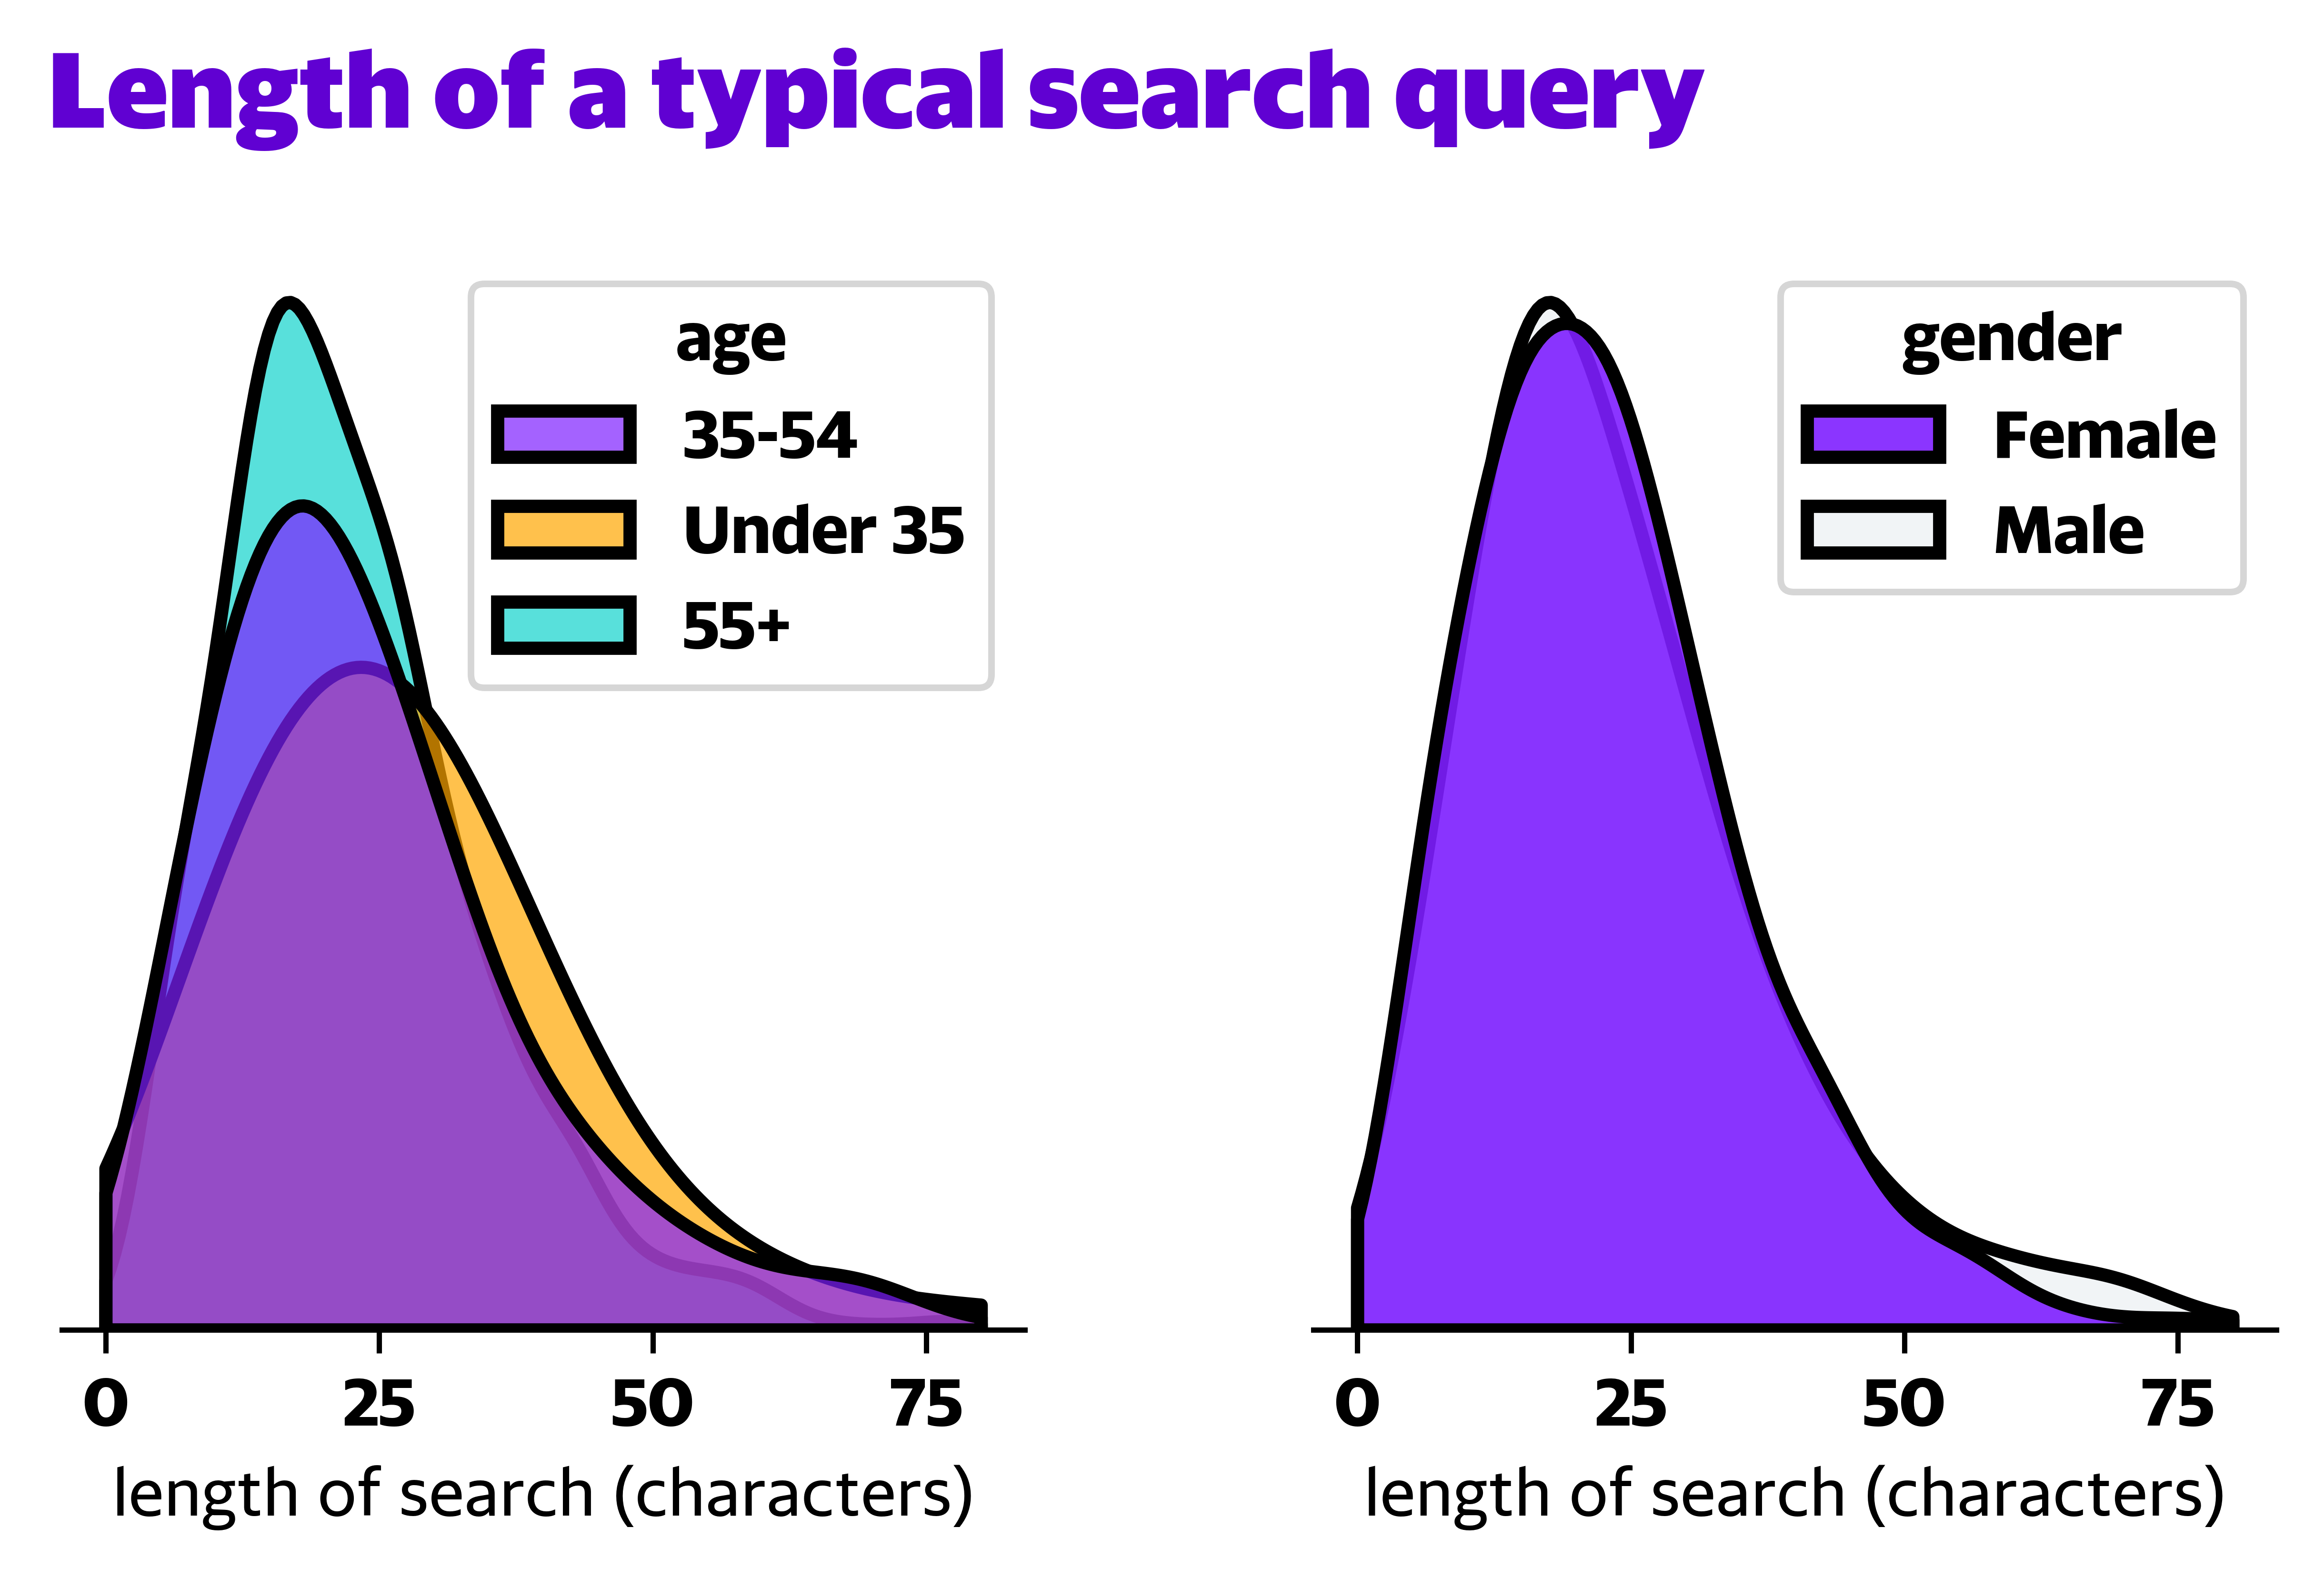

In [147]:
venn = pd.read_csv('../raw data/demo data.csv').query('age not in "Unknown" and gender not in "Unknown"').assign(length=venn.search.str.len(), month=pd.to_datetime(venn['date']).dt.month)

male = venn.query('gender == "Male"')
female = venn.query('gender =="Female"')
yahoo_palette_strict = "#7E1FFF #FFA700 #11D3CD #0F69FF #FF0080 #C7CDD2".split()
sns.set_palette(yahoo_palette_strict)


fig = plt.figure(figsize=(6,3), dpi=1000)
gs = fig.add_gridspec(1, 2)
ax=[None for i in range(2)]
ax[0] = fig.add_subplot(gs[0,0]) #add first plot to grid
ax[1] = fig.add_subplot(gs[0,1]) #add second plot to grid
gs.update(wspace=0.3, hspace=0.2)

# create kde plots to show density of distribution
sns.kdeplot(data=venn, x='length', hue='age', clip=(0,80), legend=True, common_norm=False, ax=ax[0], ec='black',shade=True, alpha=0.7, lw=2, zorder=3, cut=5)
sns.kdeplot(data=venn, x='length', hue='gender', clip=(0,80), palette=['#7E1FFF', '#F0F3F5'], legend=True, common_norm=False, ax=ax[1], ec='black',shade=True, alpha=0.9, lw=2, zorder=3)


# Aesthetics
for plot in [0,1]:
  ax[plot].get_yaxis().set_visible(False)
  ax[plot].grid(axis='y', visible=False)
  ax[plot].set_xlabel('length of search (characters)')
  ax[plot].tick_params(axis='y', which='both', bottom=False, top=False, right=False, left=False, labelsize=7, pad=0),

  for direction in ['top', 'right', 'left']:
    ax[plot].spines[direction].set_visible(False)

# Title
fig.text(x=0.12, y=0.95, s='Length of a typical search query', fontweight='extra bold', fontsize=16, va='bottom',  color='#6001D2')

plt.show()





# yahoo_palette = sns.color_palette(yahoo_palette_strict, as_cmap=True)
# fig, ax = plt.subplots(dpi=500)
# sns.kdeplot(data=venn, x='length', hue='age', fill=True, clip=(0,80), common_norm=False, lw=2, )

[(0.0, 50.0)]

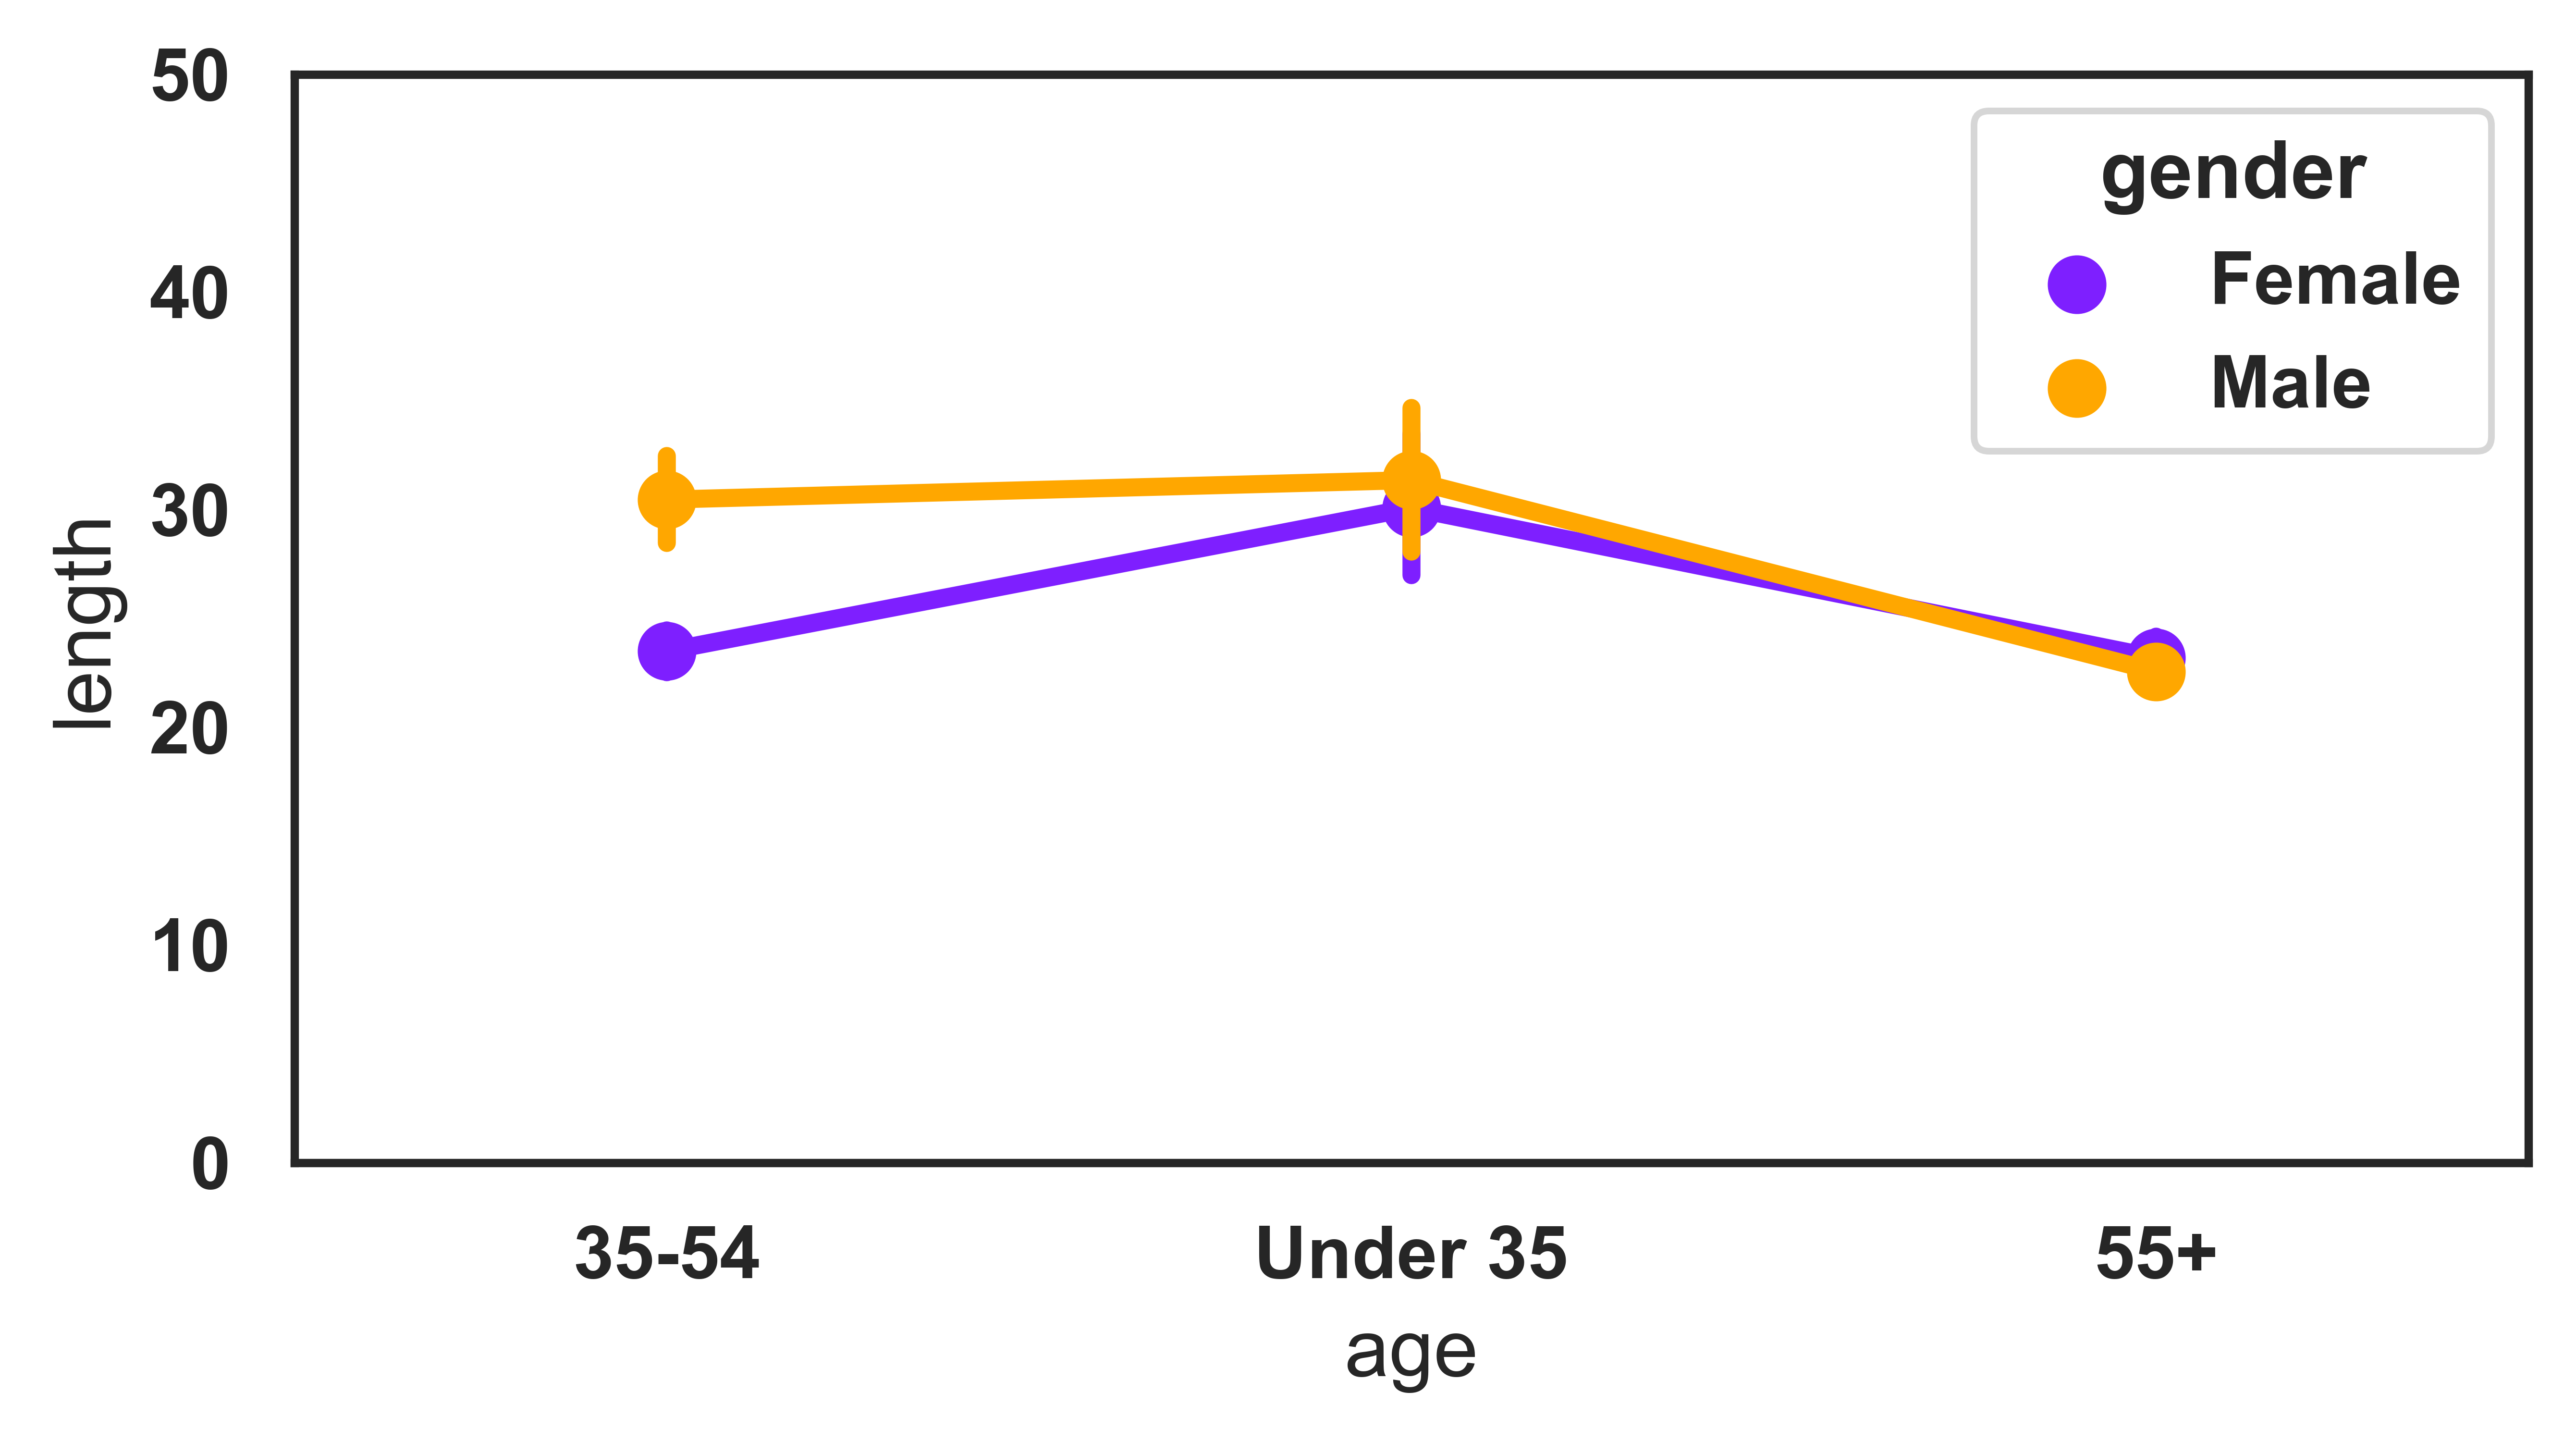

In [158]:
fig, ax = plt.subplots(figsize=(6,3), dpi=1000)
sns.set_theme(style="white")
sns.pointplot(y='length', x='age', hue='gender', data=venn, ax=ax, palette=yahoo_palette)
ax.set(ylim=(0, 50))